## Objective: To create a document term matrix for supervised learning from patent database

### Dataset from Thompson Reuters provided by Limagrain

#### Step 1: Install and load the required packages

In [1]:
#### Step 1: Install and load the required packages 
library(httr)
library(jsonlite)
library(tm)
library(tidytext)
library(wordcloud)
library(dplyr)
library(tidytext)
library(quanteda)
library(SnowballC)

setwd("../src")
patList<-read.csv("../data/excel2016-06-21-10-09-28.csv",header = TRUE)

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:httr’:

    content

Loading required package: RColorBrewer

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

quanteda version 0.9.9.17


Attaching package: ‘quanteda’

The following objects are masked from ‘package:tm’:

    as.DocumentTermMatrix, stopwords

The following object is masked from ‘package:NLP’:

    ngrams

The following object is masked from ‘jupyter:irkernel’:

    View

The following object is masked from ‘package:utils’:

    View

The following object is masked from ‘package:base’:

    sample



#### Step 2a: Load files to create dictionary

In [2]:

dic_key<- read.csv("../data/keywords.csv",header=FALSE)
dic_key<-as.character(dic_key[,1])


##### remove leading and training white spaces

In [3]:
dic_key<-trimws(dic_key)

##### remove all special characters and replace them with space

In [5]:
dic_key <- gsub("[[:punct:]]", " ", dic_key)

##### remove \x96 from the character vector

In [6]:
dic_key <- gsub("\\\x96"," ",dic_key)

##### remove \x92 from the character vector

In [7]:
dic_key <- gsub("\\\x92"," ",dic_key)

##### remove \xd7 from the character vector

In [8]:
dic_key <- gsub("\\\xd7"," ",dic_key)


##### make dictionary of crop ontologies

In [9]:
dic_CO<-read.csv("CO_322.csv",header=TRUE)
dic_CO<-c(as.character(dic_CO$Trait.name),as.character(dic_CO$Attribute))

##### select only unique terms


In [10]:
dic_CO<-unique(dic_CO)


##### Combined dictionary keywords + CO terms 

In [11]:
dic_CO_Key<-c(dic_key,dic_CO)

##### Create dictionary from title terms DWPI


In [12]:
title<-as.character(patList$Title...DWPI)
ll<-NULL
for(i in 1:length(title)){
  ll<-c(ll,unlist(strsplit(title[i]," ")))   
}

##### Combined dictionary keywords + CO terms + Title terms

In [13]:
dic_CO_key_title<-c(dic_CO_Key,ll)
dic_CO_key_title<-unique(gsub(",","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub(";","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("\\(e.g.","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("e.g.","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("/its","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("\\(","",dic_CO_key_title))
dic_CO_key_title<-unique(gsub("\\)","",dic_CO_key_title))
dic_CO_key_title<-dic_CO_key_title[dic_CO_key_title != ""]


##### returns string w/o leading or trailing whitespace

In [14]:
trim <- function (x) gsub("^\\s+|\\s+$", "", x)
dic_CO_key_title<-trim(dic_CO_key_title)

##### transform to lower and get unique set of terms


In [15]:
dic_CO_key_title<-unique(tolower(dic_CO_key_title))


#### Cleanup the data in open refine and read it again

#### #write.csv(dic_CO_key_title,file="dic_CO__key_title.csv")
#### do processing in Open Refine by removing all special characters and numbers. 
#### These steps are documented in the JSON Object created by OpenRefine  file "dictionaryClearningOpenRefine.json"

In [16]:
dic_CO_key_title<- read.csv("dictionary_CO_Title_Key_From_OpenRefine.csv",header=FALSE)
dic_CO_key_title<- as.character(dic_CO_key_title[,1])
dic_CO_key_title<- unique(dic_CO_key_title)

##### create key value pair 


In [17]:
val<-dic_CO_key_title
key<-gsub(" ","_",val)
dd<-cbind(key,val)
rownames(dd)<-dd[,1]
dd<-dd[,2]

##### create a key value pair to make dictionary

In [18]:
dfd<-dictionary(dd)


##### Dump of the dictionary consisting of keywords list, Crop Ontology terms and Title terms DWPI

In [98]:
print(dic_CO_key_title)

   [1] "additive main effects"                                    
   [2] "chromosome arms"                                          
   [3] "coalescence trees"                                        
   [4] "common bean"                                              
   [5] "genotype phenotype relationship"                          
   [6] "introgression"                                            
   [7] "leaf beet"                                                
   [8] "leaf rust"                                                
   [9] "marker assisted backcrossing"                             
  [10] "participatory plant breeding"                             
  [11] "photoperiodism"                                           
  [12] "plant variety protection  pvp"                            
  [13] "potato late blight"                                       
  [14] "qtl 96 e interaction"                                     
  [15] "solanum spp"                                          

In [19]:
length(dic_CO_key_title) ## total number of terms

[1] 3725

#### Step 3: Create corpus here with multi-word dictionary terms

In [20]:
abst_dwpi<- as.character(patList$Abstract...DWPI)

In [21]:
abst_dwpi <- phrasetotoken(abst_dwpi, dfd)

mydfm <- dfm(abst_dwpi)



#### Step 4: Data Transformation


#### now keep only the keywords from the dictionary ignoring frequent words occuring in the corpus


In [22]:
mydfm<-as_data_frame(mydfm)
dtm_tib<-mydfm[,which((colnames(mydfm)%in%key))]


#### remove stop words from "english"


In [23]:
dtm_tib<-dtm_tib[,which(!(colnames(dtm_tib)%in%stopwords("english")))]


#### assign document names to the DocumentTermMatrix


In [26]:
rownames(dtm_tib)<- as.character(patList$Publication.Number)


Warning message:
“Setting row names on a tibble is deprecated.”

#### data transformation

In [28]:
dfm<-as.dfm(dtm_tib)
dtm<-as.DocumentTermMatrix(dfm)

##### remove terms that occure in only 0.1% of all documents (in short less common words)


In [29]:
dtm<-removeSparseTerms(dtm, 0.99) # this is tunable 0.6 appears to be optimal


#### Get selected metadata information

In [38]:
dfm<-as.matrix(dtm)
meta<-patList[,c("Publication.Number","Title","Publication.Date","Assignee.Applicant","Inventor","Priority.Date...Earliest")]
rownames(meta)<-meta[,1]
dtm<-merge(dfm,meta,by="row.names")


#### rearrange columnnames for metadata

In [39]:
dtm<-dtm[,c(901:906,1:900)]

write.csv(as.matrix(dtm),file="dtm_Abstracts_dwpi_CO_Key_Title.csv")

#### cross validations
#### Check for term "dna_extraction"

In [111]:
as.matrix(dtm[,1270])

dna_extraction
0
0
0
0
0
0
0
0
0
0


#### Three times in document "US20130210006A1"

In [112]:
abst_dwpi[266]

[1] "Isolating pericarp tissue from a seed sample, comprises (a) contacting the seed sample with hydrogen peroxide (H  2  O  2  ), (b) treating the seed sample with at least one enzyme consisting of proteinases, amylases, amyloglucosidases and cellulases, and (c) separating pericarp tissue from other materials in the H  2  O  2  -soaked and enzyme-treated seed sample. INDEPENDENT CLAIMS are included for:isolating pericarp nucleic acid molecules from a seed sample, comprising the steps (a)-(c) as above per se and (d) extracting nucleic acid molecules from the pericarp tissue; anddetermining the matrilineage of a plant of interest having a paternal parent and a maternal parent, comprising the steps (a)-(d) as above per se and (e) genotyping the nucleic acid molecules, where the genotype corresponds to the genotype of the maternal parent of the plant of interest. The method is useful for isolating pericarp tissue from a seed sample and isolating pericarp nucleic acid molecules for the determination of the matrilineage of a plant of interest having a paternal parent and a maternal parent (all claimed), characterization of heterotic_groups and development of phylogenetic trees and marker assisted breeding practices. The nucleic acid molecules are isolated from the pericarp tissue sample with high purity and quality in a fully-automated manner thus significantly reducing the time and expense of the isolation procedure. Preferred Method: The step (a) comprises soaking the seed sample in an aqueous solution comprising less than 10% (preferably 5%) H  2  O  2  . The step (b) comprises soaking the seed sample in a reaction mixture comprising 1 mg/ml of   Pronase   (RTM: Protease isolated from Streptomyces griseus). The method further comprises washing the seed sample to remove associated chemicals and/or materials, manual dissection of the seed sample, sonication of the seed sample of interest, rinsing the seed sample to remove solvent and/or enzymes, separating released pericarp from the seed sample and/or soaking the seed sample in a solvent. The step (d) is performed utilizing a bead-based DNA_extraction platform. The parental nucleotide sequences are not amplified from the nucleic acid molecules by PCR. The step (e) comprises amplifying nucleotide sequences from the nucleic acid molecules utilizing the PCR, and determining allelic information at a locus that is linked to a trait of interest and then comparing the allelic information with the genotype of a known second plant of interest. The step (e) is performed using a   Kaspar   (RTM: Competitive allele specific PCR) genetic analysis platform. Preferred Components: The enzyme is a non-specific protease and is   Pronase   (RTM: Protease isolated form Streptomyces griseus). The pericarp tissue comprises essentially no non-pericarp tissue. The seed sample is a single seed. The seed sample is obtained from Zea_mays. The bead-based DNA_extraction platform is   Magattract   (RTM: DNA_extraction robotic platform). The nucleic acid molecules consist of pericarp nucleic acid molecules. The genotype or haplotype of the maternal parent is deduced."

#### Three times in document "WO2013119962A1"

In [113]:
abst_dwpi[281]

[1] "Isolating pericarp tissue from a seed sample, comprises (a) contacting the seed sample with hydrogen peroxide (H  2  O  2  ), (b) treating the seed sample with at least one enzyme consisting of proteinases, amylases, amyloglucosidases and cellulases, and (c) separating pericarp tissue from other materials in the H  2  O  2  -soaked and enzyme-treated seed sample. INDEPENDENT CLAIMS are included for:isolating pericarp nucleic acid molecules from a seed sample, comprising the steps (a)-(c) as above per se and (d) extracting nucleic acid molecules from the pericarp tissue; anddetermining the matrilineage of a plant of interest having a paternal parent and a maternal parent, comprising the steps (a)-(d) as above per se and (e) genotyping the nucleic acid molecules, where the genotype corresponds to the genotype of the maternal parent of the plant of interest. The method is useful for isolating pericarp tissue from a seed sample and isolating pericarp nucleic acid molecules for the determination of the matrilineage of a plant of interest having a paternal parent and a maternal parent (all claimed), characterization of heterotic_groups and development of phylogenetic trees and marker assisted breeding practices. The nucleic acid molecules are isolated from the pericarp tissue sample with high purity and quality in a fully-automated manner thus significantly reducing the time and expense of the isolation procedure. Preferred Method: The step (a) comprises soaking the seed sample in an aqueous solution comprising less than 10% (preferably 5%) H  2  O  2  . The step (b) comprises soaking the seed sample in a reaction mixture comprising 1 mg/ml of   Pronase   (RTM: Protease isolated from Streptomyces griseus). The method further comprises washing the seed sample to remove associated chemicals and/or materials, manual dissection of the seed sample, sonication of the seed sample of interest, rinsing the seed sample to remove solvent and/or enzymes, separating released pericarp from the seed sample and/or soaking the seed sample in a solvent. The step (d) is performed utilizing a bead-based DNA_extraction platform. The parental nucleotide sequences are not amplified from the nucleic acid molecules by PCR. The step (e) comprises amplifying nucleotide sequences from the nucleic acid molecules utilizing the PCR, and determining allelic information at a locus that is linked to a trait of interest and then comparing the allelic information with the genotype of a known second plant of interest. The step (e) is performed using a   Kaspar   (RTM: Competitive allele specific PCR) genetic analysis platform. Preferred Components: The enzyme is a non-specific protease and is   Pronase   (RTM: Protease isolated form Streptomyces griseus). The pericarp tissue comprises essentially no non-pericarp tissue. The seed sample is a single seed. The seed sample is obtained from Zea_mays. The bead-based DNA_extraction platform is   Magattract   (RTM: DNA_extraction robotic platform). The nucleic acid molecules consist of pericarp nucleic acid molecules. The genotype or haplotype of the maternal parent is deduced."

#### it occurs 1's in document "US20150191771A1"

In [114]:
abst_dwpi[288]

[1] "Nondestructive, viability retaining method of sampling a plant embryo, involves removing a tissue sample or releasing and collecting cellular contents comprising at least a portion of the scutellum and/or embryonic axis region of the embryo. INDEPENDENT CLAIMS are included for the following:plant embryo;method for growing a plant;maize plant;method for data driven plant advancement; andmethod for haploid embryo discrimination. The method is useful for retaining viability of sampling a plant embryo, preferably Zea_mays  embryo, Triticum  embryo or Oryza  embryo (all claimed). The method targets immature plant tissues, exhibits early acquisition of genetic and biochemical data from which to make data driven breeding decisions, minimizes requisite DNA purification steps, reduces cost per DNA_extraction, and allows direct use of the resulting DNA for PCR analysis. Preferred Components: The sample removed comprises tissue from the coleoptilar end of the embryo, non-coleoptilar end of the embryo, or equator or middle region of the embryo. The sample is removed using a penetrant, preferably a toothpick, a pipette tip, or similar device. The cells and/or cellular content are removed using sandpaper, or similar material to abrade and retain tissue or cellular contents. The sample is removed by cell disruption digestion or by using a liquid, preferably sodium hydroxide solution to bathe the embryo for a sustained period of time. The sample is removed by slicing with a knife or a laser. Preferred Method: The method further involves performing analysis on the tissue sample or cellular contents from the embryo, and selecting an embryo based on the result of the analysis. The method is automated or semi-automated. The embryo is at the non-mature stage of development. The method further involves collecting cells or cellular contents from the liquid. The removed sample is subjected to genetic, chemical or biochemical analysis."

##### create term frequency

In [115]:
termFreq <- colSums(as.matrix(dtm))


In [117]:
head(termFreq)
tf <- data.frame(term = names(termFreq), freq = termFreq)
tf <- tf[order(-tf[,2]),]
head(tf)


identifying         maize         plant      displays     increased 
          497          1889          6474            90           555 
culturability 
            8

,term,freq
plant,plant,6474
least,least,2823
one,one,2583
corn,corn,1979
acid,acid,1938
maize,maize,1889


#### Step 5: Visualize word cloud of terms

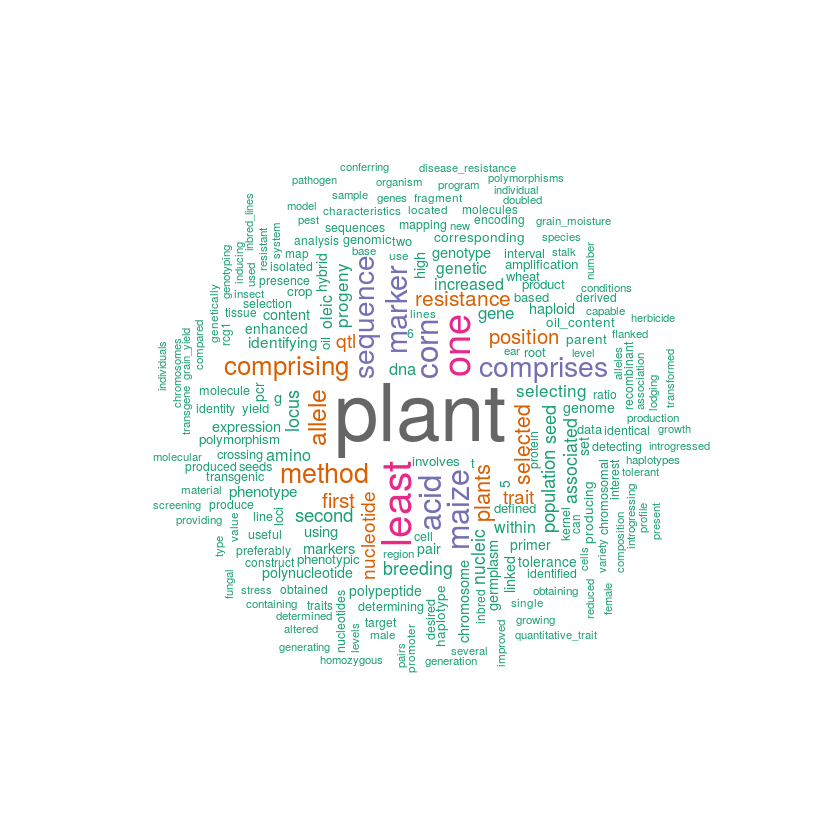

In [119]:
set.seed(1234)
suppressWarnings(wordcloud(words = tf$term, freq = tf$freq, min.freq = 100,
          max.words=8000, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2")))


#### Step 6 : Explore frequent terms and their associations


##### frequent terms

In [120]:
findFreqTerms(dtm, lowfreq = 500)

[1] "maize"      "plant"      "increased"  "one"        "allele"    
 [6] "associated" "marker"     "locus"      "within"     "method"    
[11] "selecting"  "first"      "second"     "progeny"    "plants"    
[16] "comprises"  "seed"       "gene"       "least"      "sequence"  
[21] "comprising" "nucleotide" "selected"   "amino"      "acid"      
[26] "dna"        "nucleic"    "corn"       "breeding"   "genetic"   
[31] "population" "trait"      "resistance" "qtl"        "oleic"     
[36] "position"

##### frequent associations

In [123]:
findAssocs(dtm, terms = "dna_extraction", corlimit = 0.3)


$dna_extraction
        hydrogen         peroxide         amylases          robotic 
            0.97             0.97             0.97             0.79 
          sample        materials         pericarp        utilizing 
            0.78             0.71             0.70             0.68 
          enzyme heterotic_groups       separating 
            0.48             0.43             0.35

##### Plot word frequency for first 10 terms

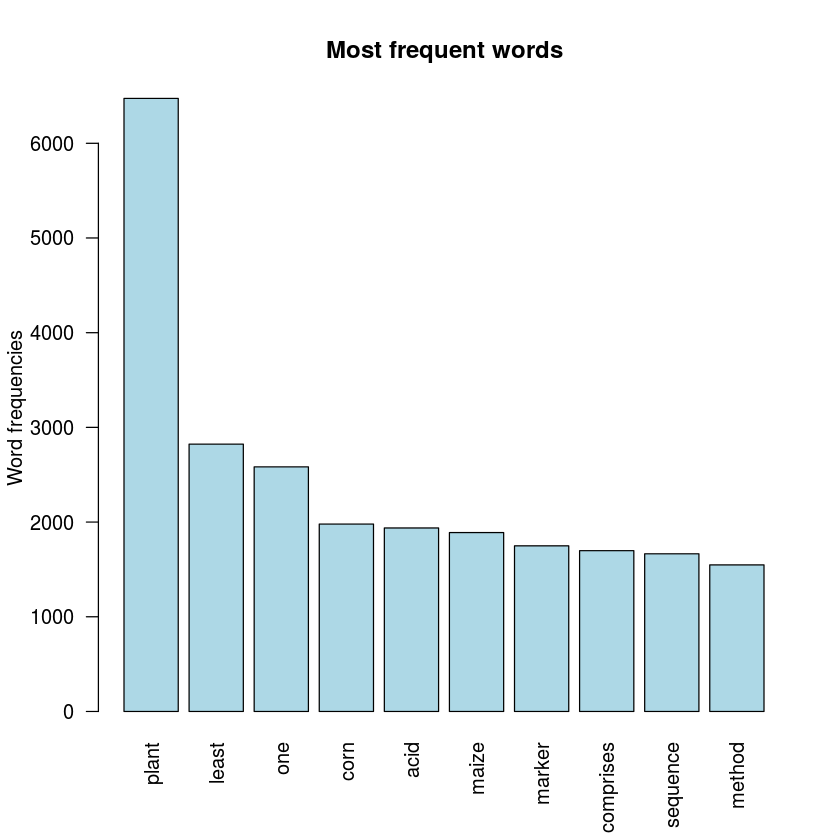

In [124]:
d<-barplot(tf[1:10,]$freq, las = 2, names.arg = tf[1:10,]$term,
           col ="lightblue", main ="Most frequent words",
           ylab = "Word frequencies")

# Observations: 
#### Some document are not relevant to maize for example:
#### Document number : "US20050078133A1" it deals with inkjet printer
#### Document identifiers are different with same content for exaample:
#### Document number "US20130266945A1" and "US9228241B2" and 
#### in total there are 30 instances like this with varying level of redundancy  
